In [154]:
import numpy as np
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
from scipy import spatial
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from scipy.linalg import fractional_matrix_power
import time
%matplotlib inline
from sklearn.model_selection import train_test_split

<font size = "5"> **Privacy Preserving Framework PPDA using MDS** </font>

In [306]:
#Function for generating data utilizing synthetic graph structures 

def data_gen(n, param):
  #g = nx.barabasi_albert_graph(n, param, seed = 10)
  #g = nx.erdos_renyi_graph(n,param, seed = 10)
  g = nx.generators.random_geometric_graph(n, param, seed = 10)
  W = np.zeros((n, n))
  for (x,y) in g.edges:
    np.random.seed(4)
    g.edges[x,y]['weight'] = np.random.uniform(low = 0.1,high = 3)

  A = nx.adjacency_matrix(g)
  W_hat = np.array(A.todense())
  L = np.diag(np.matmul(W_hat,np.ones(W_hat.shape[0]))) - W_hat
  
  return L,g,W_hat

#Function for constructing Incomplete Distance Matrix for PPDA

def dist_approx(X_na,X_a):

  DA = cdist(X_a,X_a, metric='euclidean')                   #anchor to anchor distance
  DNA = cdist(X_na,X_a, metric='euclidean')                 #non-anchor to anchor distance 
    
  #Distances with uniform random noise

  #DNA = cdist(X_na,X_a, metric='euclidean') + np.random.normal(1,1,(X_na.shape[0], X_a.shape[0]))
  #DNA = cdist(X_na,X_a, metric='euclidean') + 0.7*np.random.uniform(0,1,(X_na.shape[0], X_a.shape[0]))
  zero_mat = np.eye((X_na.shape[0]))
  ones_mat = np.ones((X_a.shape[0],X_na.shape[0]))
  ones_mat2 =  np.ones((X_a.shape[0],X_a.shape[0]))
  D = np.array(np.vstack((np.hstack((np.zeros((X_na.shape[0],X_na.shape[0])), DNA)), np.hstack((DNA.T, DA)))))    #Incomplete distance matrix
  
  W_1 = np.array(np.vstack((np.hstack((zero_mat,ones_mat.T)), np.hstack((ones_mat, ones_mat2)))))          #Weight matrix


  V = np.array(np.diag(np.matmul(W_1,np.ones(W_1.shape[0]))) - W_1)      #V matrix required for SMACOF
 

  V1=V[:X_na.shape[0],:X_na.shape[0]]
  V2=V[:X_na.shape[0],X_na.shape[0]:]

  return D, V, V1, V2, W_1, DA, DNA

#Function for learning embeddings through MDS

def classical_MDS_X(D, V, W_1, n,d):

  epsilon= 1e-3
 
  D_inv = np.reciprocal(D,  out = np.zeros_like(D), where=(D!=0))

  L_D_inv = np.diag(np.matmul(D_inv,np.ones(D_inv.shape[0]))) - D_inv
  print(L_D_inv) 
  Zu = np.random.multivariate_normal(np.zeros(n), np.linalg.pinv(L_D_inv), 60).T
  np.random.seed(10)  
  #Zu = np.random.normal(0,1,(n, 100))               #Initializing Embeddings
  epochs = 5000
  loss = []
  V_inv = np.linalg.pinv(V)

  W_new = np.multiply(W_1,D)
  print(W_new)

  D_new = cdist(Zu,Zu, metric='euclidean')
    
  #SMACOF implementation

  for t in tqdm(range(epochs)):
    
   
    W_final = np.divide(W_new,D_new, out = np.zeros_like(W_new), where=(D_new!=0))
    B_Z = np.diag(np.matmul(W_final,np.ones(W_final.shape[0]))) - W_final 
    X_final = np.matmul(np.matmul(V_inv, B_Z), Zu)
    D_new = cdist(X_final,X_final, metric='euclidean')
    D_inv_new = np.reciprocal(D_new ,  out = np.zeros_like(D_new), where=(D_new!=0))
    W_upper_triag = np.array(D_inv_new[np.triu_indices(D_inv_new.shape[0], k = 1)])
    C = np.square(D - D_new)
    D_upper_triag = C[np.triu_indices(C.shape[0], k = 1)]
    stress = np.dot(W_upper_triag, D_upper_triag)
    loss.append(stress)
    Zu = X_final
    if t % 10 == 0:
       print(stress)
    
    if t!=0:
      if abs(loss[t]-loss[t-1]) < epsilon:
        break
    
  return X_final, loss

#Function for learning embeddings through Anchored-MDS 

def MDS_X(D, V1, V2, W_1, DA,X_na, X_a, n,d):
    
  print(D)
  D_inv = np.reciprocal(D,  out = np.zeros_like(D), where=(D!=0))

  L_D_inv = np.diag(np.matmul(D_inv,np.ones(D_inv.shape[0]))) - D_inv

  np.random.seed(32)
  Zu_samples = np.random.multivariate_normal(np.zeros(X_na.shape[0] + X_a.shape[0]), np.linalg.pinv(L_D_inv),d).T
  Zu = Zu_samples[:n,:]                    #Intializing Embeddings


  
  epsilon= 1e-3
  epochs = 5000
  loss = []
  V1_inv = np.linalg.pinv(V1)

  W_new = np.multiply(W_1,D)

  DNA_new = cdist(Zu,X_a, metric='euclidean')
  D_new = np.array(np.vstack((np.hstack((np.zeros((X_na.shape[0],X_na.shape[0])), DNA_new)), np.hstack((DNA_new.T, DA)))))
  for t in tqdm(range(epochs)):
   
    W_final = np.divide(W_new,D_new, out = np.zeros_like(W_new), where=(D_new!=0))

    B_Z = np.diag(np.matmul(W_final,np.ones(W_final.shape[0]))) - W_final 

    BZ1 = B_Z[:X_na.shape[0],:X_na.shape[0]]
    BZ2 = B_Z[:X_na.shape[0],X_na.shape[0]:]

    term1 = np.matmul(BZ1,Zu)
    term2_temp = BZ2 - V2
    term2 = np.matmul(term2_temp, X_a)


    X_final = np.matmul(V1_inv,(term1 + term2))

    DNA_new = cdist(X_final,X_a, metric='euclidean')   
    D_new = np.array(np.vstack((np.hstack((np.zeros((X_na.shape[0],X_na.shape[0])), DNA_new)), np.hstack((np.transpose(DNA_new), DA)))))
    D_inv_new = np.reciprocal(D_new ,  out = np.zeros_like(D_new), where=(D_new!=0))
    W_upper_triag = np.array(D_inv_new[np.triu_indices(D_inv.shape[0], k = 1)])

    C = np.square(D - D_new)
    
    D_upper_triag = C[np.triu_indices(C.shape[0], k = 1)]

    
    stress = np.dot(W_upper_triag, D_upper_triag)

    loss.append(stress)
    Zu = X_final
    if t % 10 == 0:
       print(stress)
    
    if t!=0:
      if abs(loss[t]-loss[t-1]) < epsilon:
        break
    
  return X_final, loss

#Functions for demonstarting use case with partial inter-client distances known

#Function for computing partial distances

def partial_dist(X_na, n, r):
  D_true = cdist(X_na, X_na, metric='euclidean')
  k = int(n*(n-1)/2)
  z_true = spatial.distance.squareform(D_true)
  unknown = k - int(r*k)
  random.seed(10)
  indices = random.sample(range(0, k), unknown)
  z_true[indices] = 0
  D_partial = spatial.distance.squareform(z_true)
  
  return D_partial

#Function for computing incomplete distance matrix with partial distances known

def dist_approx_partial(X_na,X_a,D_partial):

  DA = cdist(X_a,X_a, metric='euclidean')
  DNA = cdist(X_na,X_a, metric='euclidean')
  zero_mat = np.eye((X_na.shape[0]))
  ones_mat = np.ones((X_a.shape[0],X_na.shape[0]))
  ones_mat2 =  np.ones((X_a.shape[0],X_a.shape[0]))
  
  D = np.array(np.vstack((np.hstack((D_partial, DNA)), np.hstack((DNA.T, DA)))))
  D_partial[D_partial > 0] = 1
  np.fill_diagonal(D_partial, 1)
  W_1 = np.array(np.vstack((np.hstack((D_partial,ones_mat.T)), np.hstack((ones_mat, ones_mat2)))))
  V = np.array(np.diag(np.matmul(W_1,np.ones(W_1.shape[0]))) - W_1)
  V1 = V[:X_na.shape[0],:X_na.shape[0]]
  V2 = V[:X_na.shape[0],X_na.shape[0]:]

  return D, V1, V2, W_1, DA, DNA

def MDS_X_partial(D, V1, V2, W_1, DA,X_na, X_a, n,d,r):

  D_inv = np.reciprocal(D,  out = np.zeros_like(D), where=(D!=0))
  L_D_inv = np.diag(np.matmul(D_inv,np.ones(D_inv.shape[0]))) - D_inv
  np.random.seed(32)
  Zu_samples = np.random.multivariate_normal(np.zeros(X_na.shape[0] + X_a.shape[0]), np.linalg.pinv(L_D_inv),d).T

  Zu = Zu_samples[:X_na.shape[0]]          #Initializng Embeddings

  
  epsilon= 1e-3
  epochs = 5000
  loss = []
  V1_inv = np.linalg.pinv(V1)

  W_new = np.multiply(W_1,D)

  W_upper_triag = np.array(W_1[np.triu_indices(W_1.shape[0], k = 1)])

  DNA_new = cdist(Zu,X_a, metric='euclidean')
  D_X_partial = partial_dist(Zu, n, r)
  D_new = np.array(np.vstack((np.hstack((D_X_partial, DNA_new)), np.hstack((DNA_new.T, DA)))))
  for t in tqdm(range(epochs)):

    W_final = np.divide(W_new,D_new, out = np.zeros_like(W_new), where=(D_new!=0))

    B_Z = np.diag(np.matmul(W_final,np.ones(W_final.shape[0]))) - W_final 

    BZ1 = B_Z[:X_na.shape[0],:X_na.shape[0]]
    BZ2 = B_Z[:X_na.shape[0],X_na.shape[0]:]
  
    term1 = np.matmul(BZ1,Zu)
    term2_temp = BZ2 - V2
    term2 = np.matmul(term2_temp, X_a)


    X_final = np.matmul(V1_inv,(term1 + term2))

    DNA_new = cdist(X_final,X_a, metric='euclidean')
    D_X_partial = partial_dist(X_final, n, r)
    
    D_new = np.array(np.vstack((np.hstack((D_X_partial, DNA_new)), np.hstack((np.transpose(DNA_new), DA)))))
    
    C = np.square(D - D_new)
    D_upper_triag = C[np.triu_indices(C.shape[0], k = 1)]
    stress = np.dot(W_upper_triag, D_upper_triag)

    loss.append(stress)
    Zu = X_final
    if t % 10 == 0:
       print(stress)
    
    if t!=0:
      if abs(loss[t]-loss[t-1]) < epsilon:
        break
    
  return X_final, loss

#Function for computing error in estimation of distances

def dist_error(X_na, X_final):
  
  D_true = cdist(X_na, X_na, metric='euclidean')
  z_true = spatial.distance.squareform(D_true)

  D_esti = cdist(X_final, X_final, metric='euclidean')
  z_esti = spatial.distance.squareform(D_esti) 
  Error = np.linalg.norm((D_true - D_esti), 'fro')/ np.linalg.norm((D_true), 'fro')
  
  return Error, D_true, D_esti, z_true, z_esti

#Function for checking F-score for neighborhood structure preservation, where k is the number of nearest neighbor
#Input (k+1)  for k-NN as we are not considering distance of node from itself.

def check_score(D_true, D_approx,k):
      f_scores = []
      for i in range(D_true.shape[0]):
        list1 =  np.argsort(D_true[i])
        list2 =  np.argsort(D_approx[i])
        newlist1 = list1[1:k]
        newlist2 = list2[1:k]
        count = 0
        for p in range(k-1):
          for q in range(k-1):
            if(newlist1[p] == newlist2[q]):
              count += 1
              break;
        
        f_score = 2*count/(2*count + (k- 1 - count))
        f_scores.append(f_score)
        
      avg_f_score = sum(f_scores)/len(f_scores)

      return avg_f_score

In [260]:
n = 100              #Number of non-anchors
param = 0.1
d = 700               #Dimensionality of data

L_na, g_na, W_na = data_gen(n + d - 1, param)         
#L_na, g_na, W_na = data_gen(n, param)    
np.random.seed(8)
X_temp = np.random.multivariate_normal(np.zeros(n + d - 1), np.linalg.pinv(L_na),d).T         #Creating IGMRF model for generating samples           
#X_na = np.random.multivariate_normal(np.zeros(n), np.linalg.pinv(L_na),d).T       
X_na = X_temp[:n,:]   #Set of non-anchors
print("Size of original features", X_na.shape)

X_a = X_temp[n:,:]    #Set of anchors
#X_a = np.random.randn((d-1), d)
print("Size of reference nodes(anchors)", X_a.shape)

X = np.vstack((X_na, X_a))

nodes = X.shape[0]    #Total number of nodes including anchors and non-anchors


C:\Users\nimes\AppData\Local\Temp\ipykernel_45112\1143188240.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(g)


Size of original features (100, 700)
Size of reference nodes(anchors) (699, 700)


In [ ]:
#1) Using Anchored MDS:

D, V, V1, V2, W_1, DA, DNA = dist_approx(X_na.astype('float'), X_a.astype('float'))
X_final, loss = MDS_X(D, V1, V2, W_1, DA, X_na.astype('float'), X_a.astype('float'), n, d)
error, D_true, D_esti, z_true, z_esti = dist_error(X_na.astype('float'), X_final)
print("Error in distance approximation: ", error)
fscore = check_score(D_true, D_esti, 11)
print("F-score: ", fscore)


In [ ]:
#2) For use case with partial distances known: 

r = 0.5                      #Ratio of known distances with respect to total inter-client distances

D_partial = partial_dist(X_na, n, r)
D, V1, V2, W_1, DA, DNA= dist_approx_partial(X_na, X_a,D_partial)
X_final, loss = MDS_X_partial(D, V1, V2, W_1, DA, X_na, X_a, n, d, r)
#print(X_final)
error, D_true, D_esti, z_true, z_esti = dist_error(X_na, X_final)
print("Error in distance approximation: ", error)
fscore = check_score(D_true, D_esti, 11)
print("F-score: ", fscore)

In [ ]:
#3) Using classical MDS:

X_a = X_a[:,:]
print("Size of reference nodes(anchors)", X_a.shape)

X = np.vstack((X_na, X_a))

nodes = X.shape[0]
D, V, V1, V2, W_1, DA, DNA = dist_approx(X_na.astype('float'), X_a.astype('float'))
X_final, loss = classical_MDS_X(D, V, W_1, nodes,d)
error, D_true, D_esti, z_true, z_esti = dist_error(X_na.astype('float'), X_final[:X_na.shape[0], :])
print("Error in distance approximation: ", error)
fscore = check_score(D_true, D_esti, 11)
print("F-score: ", fscore)

In [ ]:
#Validating Results 

print(X_final.shape)
#embed_anc = X_final[X_na.shape[0] : , :]
#embed_non_anc = X_final[:X_na.shape[0], :]
embed_non_anc = X_final
print("Embeddings:",embed_non_anc)
print("Original data:",X_na)
print("Estimated distance:", cdist(embed_non_anc,embed_non_anc, metric='euclidean'))
print("True distance:", D_true)
print("Anchor to Anchor Distance: ", DA)
print("Anchor to Non-anchor distance: ", DNA)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


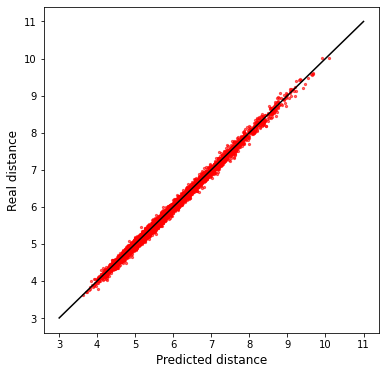

In [171]:
# True euclidean distance (vertical axis) vs. predicted euclidean distance (horizontal axis) plot for PPDA
fig = plt.figure(figsize=(6,6)) 
plt.scatter( z_esti,z_true, s = 5, c = 'red', alpha = 0.6)
plt.plot( [3,11], [3,11], color='black', linestyle = '-' )
plt.xlabel("Predicted distance", fontsize = 12)
plt.ylabel("Real distance",fontsize = 12)
plt.savefig("C:/Users/nimes/OneDrive/Desktop/RGG_n = {}_d = {}_p = {}_learnt.eps".format(n,d,param))
plt.show()

In [ ]:
#Plot of Loss vs epochs:
fig = plt.figure(figsize=(10,10)) 
plt.plot(np.arange(0, len(loss) - 10), loss[10:] )
plt.show()

<font size = "5"> **Noise Analysis** </font>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


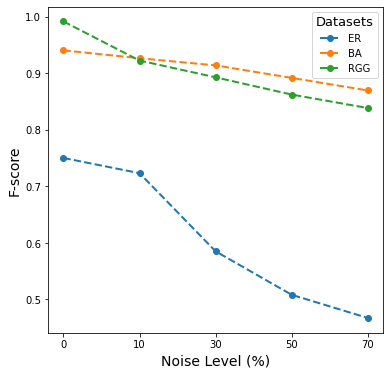

In [172]:
noise_level = [0, 0.1, 0.3, 0.5, 0.7]

#ER : 

f_score_ER = [0.7503, 0.7234, 0.5852, 0.5083, 0.4673]
RDE_ER = [0.0292, 0.0543,0.1365, 0.2194,0.3006]
#BA :

f_score_BA = [0.9406, 0.9267, 0.9140,0.8919, 0.8697]
RDE_BA = [0.0157, 0.0220, 0.045, 0.0710, 0.0968]
#RGG :

f_score_RGG = [0.9917, 0.9226, 0.8929, 0.8624, 0.8386]
RDE_RGG = [0.0127, 0.0210, 0.0511, 0.0819, 0.1125]

fig = plt.figure(figsize=(6,6)) 
default_x_ticks = range(len(noise_level))
plt.plot(default_x_ticks, f_score_ER, 'o--', linewidth=2)
plt.plot(default_x_ticks, f_score_BA, 'o--', linewidth=2)
plt.plot(default_x_ticks, f_score_RGG, 'o--', linewidth=2)

#customization

plt.xticks(default_x_ticks, [0,10,30,50,70])
plt.xlabel('Noise Level (%)', fontsize = 14)
plt.ylabel('F-score', fontsize = 14)
plt.legend(title='Datasets', title_fontsize = 13, labels=['ER', 'BA', 'RGG'])
plt.savefig("C:/Users/nimes/OneDrive/Desktop/noise_f-score.eps")
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


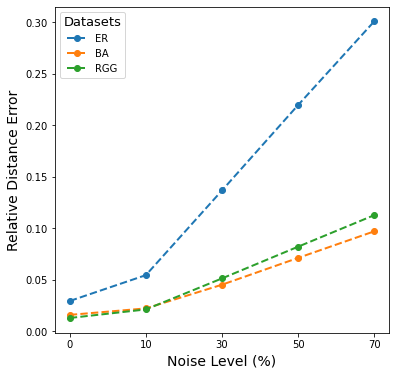

In [173]:
from matplotlib.ticker import StrMethodFormatter
fig = plt.figure(figsize=(6,6)) 
default_x_ticks = range(len(noise_level))
plt.plot(default_x_ticks, RDE_ER, 'o--', linewidth=2)
plt.plot(default_x_ticks, RDE_BA, 'o--', linewidth=2)
plt.plot(default_x_ticks, RDE_RGG, 'o--', linewidth=2)

#customization

plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xticks(default_x_ticks, [0,10,30,50,70])
plt.xlabel('Noise Level (%)', fontsize = 14)
plt.ylabel('Relative Distance Error', fontsize = 14)
plt.legend(title='Datasets', title_fontsize = 13, labels=['ER', 'BA', 'RGG'])
plt.savefig("C:/Users/nimes/OneDrive/Desktop/noise_RDE.eps")
plt.show()
